In [130]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [131]:
df=pd.read_csv('Mall_Customers - Mall_Customers.csv')
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [132]:
df.columns.tolist()

['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [134]:
df.duplicated().sum()

0

In [135]:
df["CustomerID"].nunique()

200

In [136]:
df.set_index("CustomerID", inplace=True)

In [137]:
df.head(10)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
6,Female,22,17,76
7,Female,35,18,6
8,Female,23,18,94
9,Male,64,19,3


- The dataframe included 5 cols 'CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'
- It contains 200 rows no nulls nor duplicated entries
- The customer_id column has 200 unique values, replaced it with the index

In [138]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


- It appears there are a few outliers in annual income and age to make sure i will visualize later

In [139]:
df.describe(include='object')

,Gender
count,200
unique,2
top,Female
freq,112


In [140]:
GenderPrec=df['Gender'].value_counts(normalize=True)
GenderPrec

Gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64

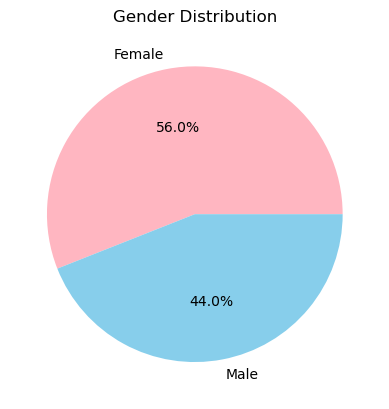

In [141]:
plt.pie(GenderPrec, labels=['Female','Male'], autopct='%1.1f%%', colors=['lightpink','skyblue'])
plt.title('Gender Distribution')
plt.show()

In [142]:
GenderAgeMean=df.groupby('Gender')[['Age']].mean().reset_index()
GenderAgeMean

,Gender,Age
0,Female,38.098214
1,Male,39.806818


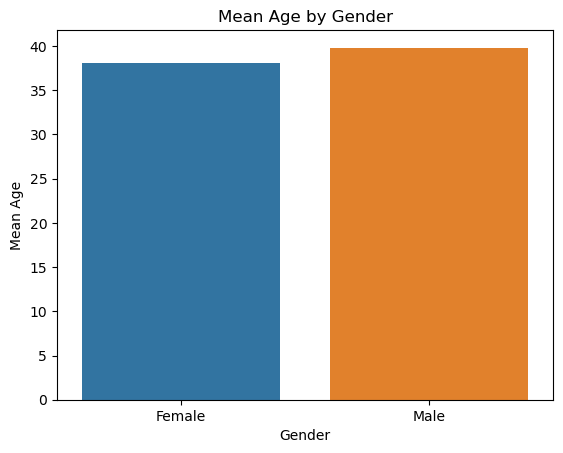

In [143]:
sns.barplot(x='Gender', y='Age', data=GenderAgeMean)
plt.title('Mean Age by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Age')
plt.show()

In [144]:
GenderIncome=df.groupby('Gender')[['Annual Income (k$)']].mean().reset_index()
GenderIncome

,Gender,Annual Income (k$)
0,Female,59.250000
1,Male,62.227273


In [145]:
GenderScore=df.groupby('Gender')[['Spending Score (1-100)']].sum().reset_index()
GenderScore

,Gender,Spending Score (1-100)
0,Female,5771
1,Male,4269


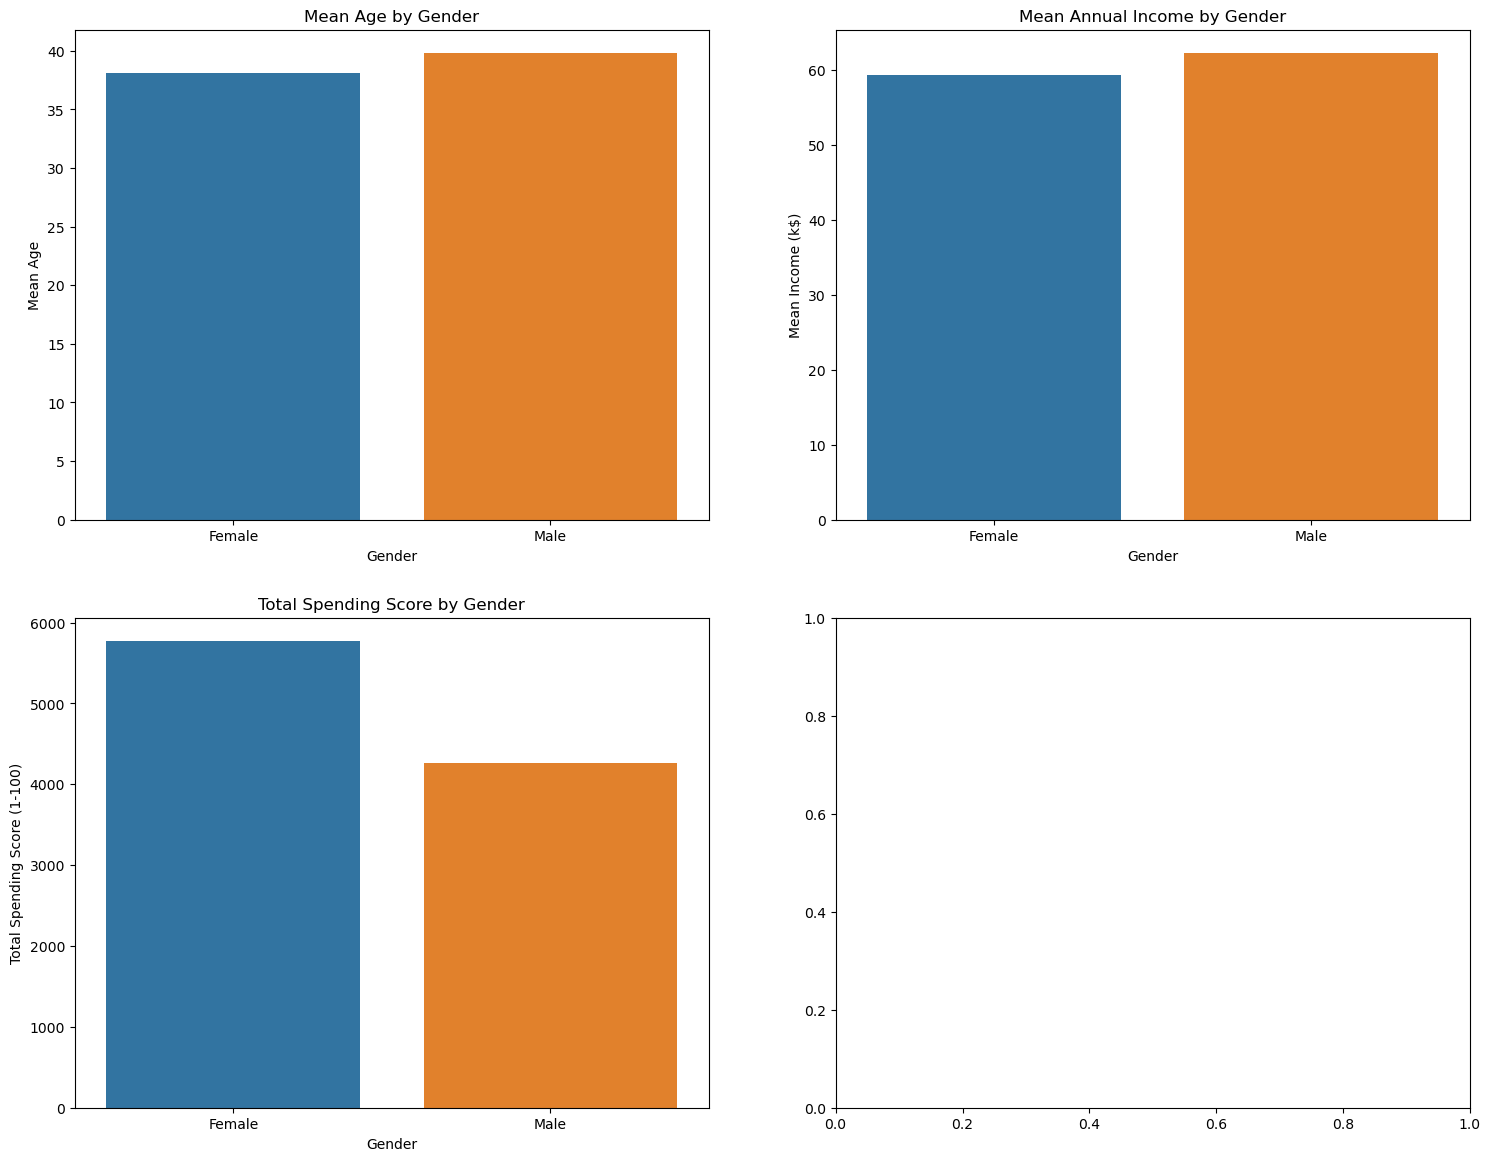

In [146]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

sns.barplot(x='Gender', y='Age', data=GenderAgeMean, ax=axes[0][0])
axes[0][0].set_title('Mean Age by Gender')
axes[0][0].set_xlabel('Gender')
axes[0][0].set_ylabel('Mean Age')

sns.barplot(x='Gender', y='Annual Income (k$)', data=GenderIncome, ax=axes[0][1])
axes[0][1].set_title('Mean Annual Income by Gender')
axes[0][1].set_xlabel('Gender')
axes[0][1].set_ylabel('Mean Income (k$)')

sns.barplot(x='Gender', y='Spending Score (1-100)', data=GenderScore, ax=axes[1][0])
axes[1][0].set_title('Total Spending Score by Gender')
axes[1][0].set_xlabel('Gender')
axes[1][0].set_ylabel('Total Spending Score (1-100)')

# Show the plot
plt.show()

- There are more females in the dataset than males(biased towards females)
- The average age of males and females are nearly the same 38.
- The annual income of male custumers are higher than females.
- Female spending score is higher than males.

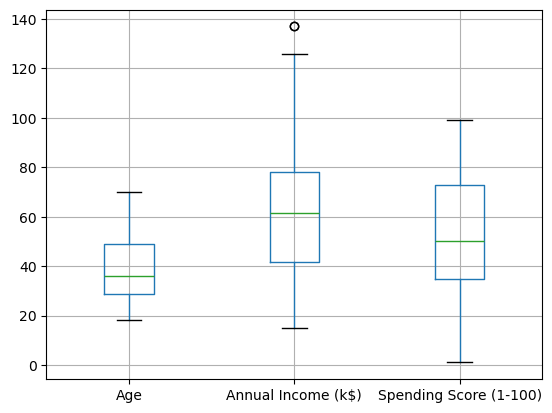

In [147]:
df.boxplot(column=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
plt.show()

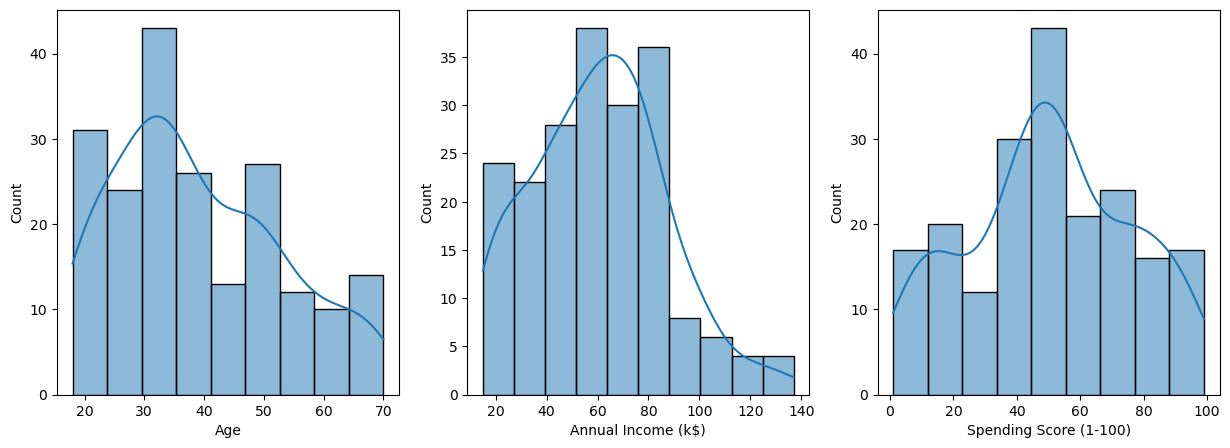

In [148]:
fig,axes=plt.subplots(1,3, figsize=(15,5))

sns.histplot(df['Age'], kde=True,ax=axes[0])
sns.histplot(df['Annual Income (k$)'],kde=True, ax=axes[1])
sns.histplot(df['Spending Score (1-100)'],kde=True, ax=axes[2])
plt.show()

- There are no outliers in Age, Spending Score
- There are outliers in Annual Income
- I will check the skewness and kertosis and try to treat the outliers before removing them

In [149]:
df['AnnualSqrt']=np.sqrt(df['Annual Income (k$)'])
df['Annuallog']=np.log(df['Annual Income (k$)'])
df.head(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100),AnnualSqrt,Annuallog
CustomerID,,,,,,
1,Male,19,15,39,3.872983,2.708050
2,Male,21,15,81,3.872983,2.708050
3,Female,20,16,6,4.000000,2.772589
4,Female,23,16,77,4.000000,2.772589
5,Female,31,17,40,4.123106,2.833213


In [150]:
print(df['Annual Income (k$)'].skew())
print(df['AnnualSqrt'].skew())
print(df['Annuallog'].skew())

0.3218425498619055
-0.23028952579486217
-0.7596281254451491


In [151]:
print(df['Annual Income (k$)'].kurt())
print(df['AnnualSqrt'].kurt())
print(df['Annuallog'].kurt())

-0.09848708652696203
-0.4307009169861331
-0.05553982346259412


In [152]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100),AnnualSqrt,Annuallog
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000,7.581243,3.991378
std,13.969007,26.264721,25.823522,1.760753,0.507336
min,18.000000,15.000000,1.000000,3.872983,2.708050
25%,28.750000,41.500000,34.750000,6.441694,3.725472
50%,36.000000,61.500000,50.000000,7.842129,4.119004
75%,49.000000,78.000000,73.000000,8.831761,4.356709
max,70.000000,137.000000,99.000000,11.704700,4.919981


- While the Annual log wasnt effictive, the annual square root was somehow effictive but there is still a bit of outliers
- so i will remove the outliers since they are not alot

In [153]:
Q1=df['Annual Income (k$)'].quantile(0.25)
Q2=df['Annual Income (k$)'].quantile(0.50)
Q3=df['Annual Income (k$)'].quantile(0.75)
IQR=Q3-Q1
LB=Q1-1.5*IQR
UB=Q3+1.5*IQR
df[(df['Annual Income (k$)']>UB)|(df['Annual Income (k$)']<LB)]

,Gender,Age,Annual Income (k$),Spending Score (1-100),AnnualSqrt,Annuallog
CustomerID,,,,,,
199,Male,32,137,18,11.7047,4.919981
200,Male,30,137,83,11.7047,4.919981


In [154]:
df=df.drop(['AnnualSqrt','Annuallog'], axis=1)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [155]:
df= df[(df['Annual Income (k$)'] >= LB) & (df['Annual Income (k$)'] <= UB)]
df.tail()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
194,Female,38,113,91
195,Female,47,120,16
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [156]:
numerical_columns = df.select_dtypes(include="number").columns.to_list()
corr_matrix=df[numerical_columns].corr()
corr_matrix

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,0.004406,-0.329421
Annual Income (k$),0.004406,1.000000,0.010080
Spending Score (1-100),-0.329421,0.010080,1.000000


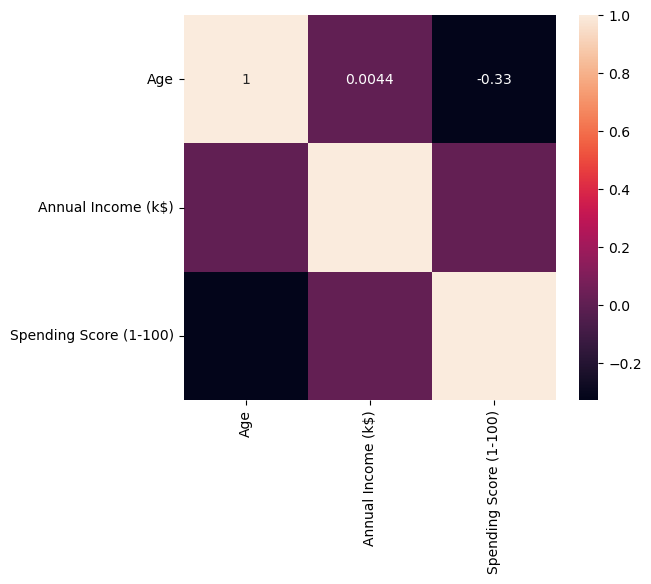

In [157]:
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

- Between annual income and age nearly no correlation
- The same with annual income and spending score
- there is a negative correlation between spending score and age

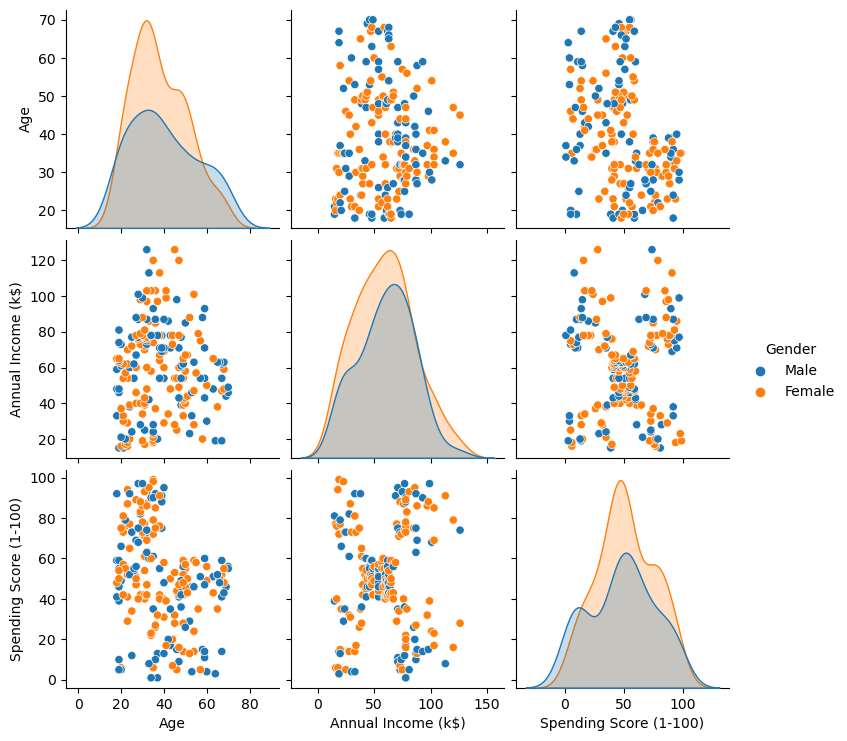

In [158]:
sns.pairplot(df[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']], hue='Gender') 
plt.show()

In [159]:
# l=LabelEncoder()
# df['GenderEncoded']= l.fit_transform(df['Gender'])
# df.drop(['GenderEncoded'], axis=1)

In [160]:
df= pd.get_dummies(df, columns=['Gender'], drop_first=True).astype(int)
df

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
CustomerID,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0
...,...,...,...,...
194,38,113,91,0
195,47,120,16,0
196,35,120,79,0


In [161]:
s= StandardScaler()
scaled_data=s.fit_transform(df)
scaled_data.shape

(198, 4)

- Used Dummies for the gender to turn object into integer
- Standerdized the data to be able to deal with it in my models

# Clustering Kmeans

In [162]:
wcss=[]
for i in range(2,11):
    kmeans= KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
    pred = kmeans.predict(df)
    print('WCSS for {} clusters: {:<.3f}'.format(i, kmeans.inertia_))
    print('Silhouette Score',i,'clusters=',silhouette_score(df,pred))

WCSS for 2 clusters: 200627.518
Silhouette Score 2 clusters= 0.29652700292331624
WCSS for 3 clusters: 138129.115
Silhouette Score 3 clusters= 0.3793577446939934
WCSS for 4 clusters: 99152.198
Silhouette Score 4 clusters= 0.40758212907644736
WCSS for 5 clusters: 70324.189
Silhouette Score 5 clusters= 0.44431704786793813
WCSS for 6 clusters: 53180.849
Silhouette Score 6 clusters= 0.459547253140841
WCSS for 7 clusters: 47698.712
Silhouette Score 7 clusters= 0.4409099531650993
WCSS for 8 clusters: 42497.313
Silhouette Score 8 clusters= 0.4187778677300123
WCSS for 9 clusters: 38798.691
Silhouette Score 9 clusters= 0.40786256604589227
WCSS for 10 clusters: 35619.218
Silhouette Score 10 clusters= 0.375651489959018


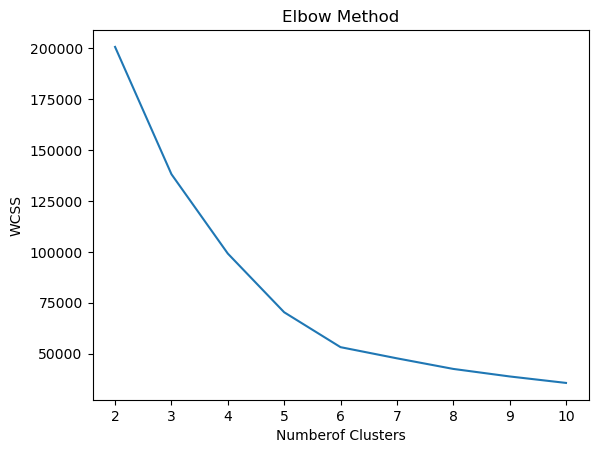

In [163]:
plt.plot(range(2,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Numberof Clusters')
plt.ylabel('WCSS')
plt.show()

- Used the normal data and the Wcss score was too big so i will used the standerdized data

# Kmeans Standerdized

In [164]:
wcss2=[]
for i in range(2,11):
    kmeans= KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss2.append(kmeans.inertia_)
    pred = kmeans.predict(scaled_data)
    print('WCSS for {} clusters: {:<.3f}'.format(i, kmeans.inertia_))
    print('Silhouette Score',i,'clusters=',silhouette_score(scaled_data,pred))

WCSS for 2 clusters: 582.682
Silhouette Score 2 clusters= 0.2509004581854643
WCSS for 3 clusters: 472.353
Silhouette Score 3 clusters= 0.260407658208033
WCSS for 4 clusters: 383.238
Silhouette Score 4 clusters= 0.3002488145775434
WCSS for 5 clusters: 322.875
Silhouette Score 5 clusters= 0.316608926368455
WCSS for 6 clusters: 271.267
Silhouette Score 6 clusters= 0.3349613464781547
WCSS for 7 clusters: 233.469
Silhouette Score 7 clusters= 0.35865872127103954
WCSS for 8 clusters: 196.935
Silhouette Score 8 clusters= 0.3901757944645718
WCSS for 9 clusters: 170.937
Silhouette Score 9 clusters= 0.40493384270034855
WCSS for 10 clusters: 147.585
Silhouette Score 10 clusters= 0.4239964706544691


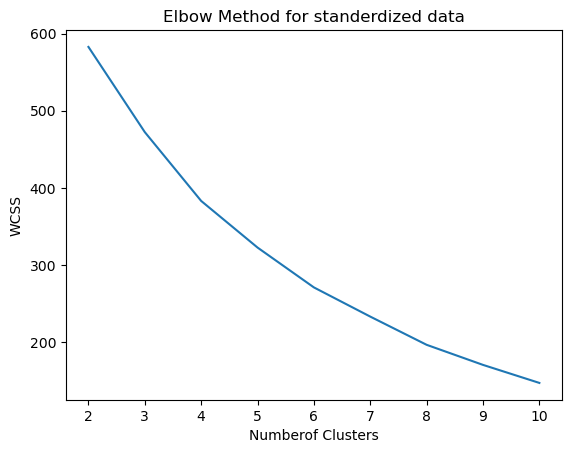

In [165]:
plt.plot(range(2,11),wcss2)
plt.title('Elbow Method for standerdized data')
plt.xlabel('Numberof Clusters')
plt.ylabel('WCSS')
plt.show()

- Using the elbow method on the data the wcss was very big
- After Standerdizing the data the WCSS was small which is good.
- the distance started to remain constant when num of clusters where 6

# Kmeans PCA

In [166]:
pca= PCA(n_components=2)
df_pca= pca.fit_transform(scaled_data)

In [167]:
print(df_pca.shape)

(198, 2)


In [168]:
wcss3=[]
for i in range(2,11):
    kmeans= KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_pca)
    wcss3.append(kmeans.inertia_)
    pred = kmeans.predict(df_pca)
    print('WCSS for {} clusters: {:<.3f}'.format(i, kmeans.inertia_))
    print('Silhouette Score',i,'clusters=',silhouette_score(df_pca,pred))

WCSS for 2 clusters: 264.657
Silhouette Score 2 clusters= 0.3995216580154133
WCSS for 3 clusters: 182.208
Silhouette Score 3 clusters= 0.38439537778510824
WCSS for 4 clusters: 124.785
Silhouette Score 4 clusters= 0.3971871816719358
WCSS for 5 clusters: 103.574
Silhouette Score 5 clusters= 0.3823429448169228
WCSS for 6 clusters: 84.783
Silhouette Score 6 clusters= 0.38914690346884184
WCSS for 7 clusters: 72.779
Silhouette Score 7 clusters= 0.37035172700979985
WCSS for 8 clusters: 64.388
Silhouette Score 8 clusters= 0.36423621930426064
WCSS for 9 clusters: 55.636
Silhouette Score 9 clusters= 0.37375438827058416
WCSS for 10 clusters: 48.914
Silhouette Score 10 clusters= 0.3737856127954675


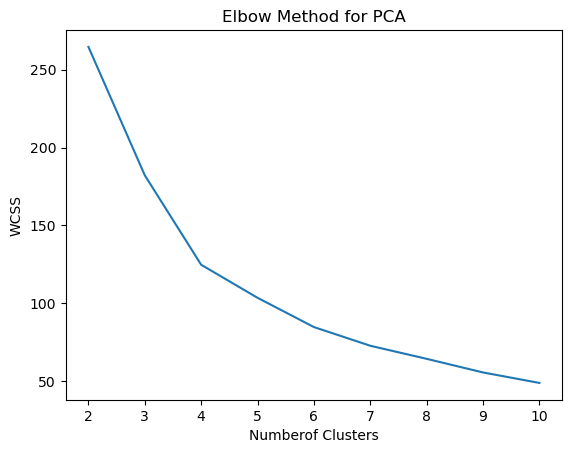

In [169]:
plt.plot(range(2,11),wcss3)
plt.title('Elbow Method for PCA')
plt.xlabel('Numberof Clusters')
plt.ylabel('WCSS')
plt.show()

In [209]:
kmeans_pca= KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_pca.fit(df_pca)
predict= kmeans_pca.predict(df_pca)


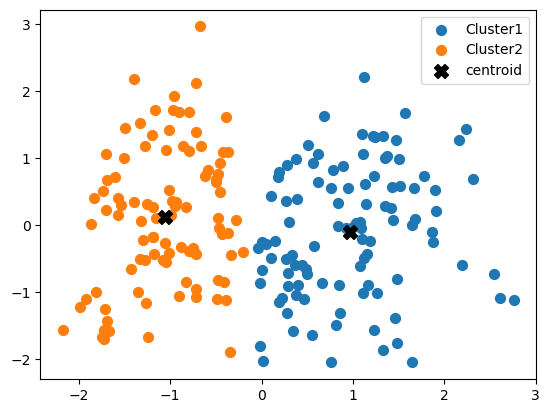

In [210]:
cores=['m','b']
for i in range(len(cores)):
    plt.scatter(df_pca[predict==i,0], df_pca[predict==i,1], s=50, label='Cluster'+str(i+1))
plt.scatter(kmeans_pca.cluster_centers_[:,0], kmeans_pca.cluster_centers_[:,1], s=100, marker='X', c='black', label='centroid')
plt.legend()
plt.show()

- The results from pca are good but it is oversimplifying my data since i dont have many feutures to begin with

# Clustering GaussianMixture

In [172]:
l=[]
for i in range(2,int((df.shape[0]//2)**0.4)):
    model= GaussianMixture(i)
    model.fit(df)
    pred=model.predict(df)
    score= silhouette_score(df,pred)
    print(score)

0.29370673434635947
0.305343870927683
0.3809323599329839
0.4215787355711919


In [173]:
aic1=[]
bic1=[]
for i in range(2,int((df.shape[0]//2)**0.4)):
    model= GaussianMixture(i)
    model.fit(df)
    aic1.append(model.aic(df))
    bic1.append(model.bic(df))

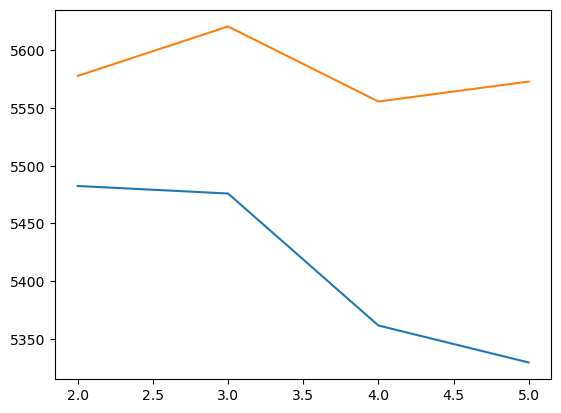

In [174]:
plt.plot(range(2,int((df.shape[0]//2)**0.4)),aic1)
plt.plot(range(2,int((df.shape[0]//2)**0.4)),bic1)
plt.show()

In [175]:
model = GaussianMixture(n_components=4)
model.fit(df)
cluster = model.predict(df)
cluster = cluster.astype(int)
df['GM_Cluster'] = cluster
df.head(5)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,GM_Cluster
CustomerID,,,,,
1,19,15,39,1,2
2,21,15,81,1,0
3,20,16,6,0,2
4,23,16,77,0,0
5,31,17,40,0,2


In [176]:
df['GM_Cluster'].value_counts(normalize=True)

GM_Cluster
2    0.383838
0    0.252525
3    0.191919
1    0.171717
Name: proportion, dtype: float64

- Based on what i analysed with kmeans:
    - When i used the normal data the scores where too big
    - So i resorted to Standerdizing my data, the scores proved much better than the normal data
    - As for the PCA it's true that the wcss scores were very good but at the same time reducing the columns to two might oversimplify the data
- As for the Gaussian Mixture:
    - The scores were great when number of clusters were 4
- So i will add Kmeans with standerdized data and Gaussian Mixture as the new clusters columns and compare between them with classification
  

In [177]:
kmeans= KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(scaled_data)
df['Kmeans_S_Cluster'] = kmeans.predict(scaled_data)
df.head(10)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,GM_Cluster,Kmeans_S_Cluster
CustomerID,,,,,,
1,19,15,39,1,2,3
2,21,15,81,1,0,3
3,20,16,6,0,2,4
4,23,16,77,0,0,0
5,31,17,40,0,2,4
6,22,17,76,0,0,0
7,35,18,6,0,2,4
8,23,18,94,0,0,0
9,64,19,3,1,2,2


In [178]:
df['Kmeans_S_Cluster'].value_counts(normalize=True)

Kmeans_S_Cluster
0    0.277778
4    0.217172
3    0.202020
1    0.161616
2    0.141414
Name: proportion, dtype: float64

# Classification

In [179]:
x= df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)','Gender_Male']]
x

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
CustomerID,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0
...,...,...,...,...
194,38,113,91,0
195,47,120,16,0
196,35,120,79,0


In [180]:
y=df[['Kmeans_S_Cluster']]
y

,Kmeans_S_Cluster
CustomerID,
1,3
2,3
3,4
4,0
5,4
...,...
194,0
195,1
196,0


In [181]:
y2=df[['GM_Cluster']]
y2

,GM_Cluster
CustomerID,
1,2
2,0
3,2
4,0
5,2
...,...
194,3
195,1
196,3


In [182]:
x_train,x_test,y_train,y_test=train_test_split(x, y,test_size=0.30, random_state=0)

In [183]:
x_train2,x_test2,y_train2,y_test2=train_test_split(x, y2,test_size=0.30, random_state=0)

In [184]:
print('train data:',x_train.shape)
print('test data:',x_test.shape)

train data: (138, 4)
test data: (60, 4)


- Creating Preformance and Grid search function

In [185]:
def preformance(model, x_train, y_train, y_pred, y_test):
    print('Training Score=',model.score(x_train,y_train))
    print('Testing Score=',r2_score(y_test,y_pred))
    print('MSE=',mean_squared_error(y_test,y_pred))
    print('MAE=', mean_absolute_error(y_test,y_pred))

In [186]:
def gridSearch(model, param, x_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

## Logistic Regression

### Kmeans clustering(standerdized data)

In [187]:
param_grid = {
    'penalty': [ None,'l1','l2','elasticnet'],
    'multi_class':['auto', 'ovr', 'multinomial'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

In [188]:
lr= LogisticRegression(C= 1, max_iter= 100, multi_class= 'auto', penalty= 'l2', solver= 'newton-cg')
lr.fit(x_train, y_train)

LogisticRegression(C=1, solver='newton-cg')

In [189]:
# gridSearch(lr, param_grid, x_train, y_train)

In [190]:
y_pred_test= lr.predict(x_test)
preformance(lr,x_train,y_train,y_pred_test,y_test)

Training Score= 1.0
Testing Score= 0.9926253687315634
MSE= 0.016666666666666666
MAE= 0.016666666666666666


### Gaussian Mixture

In [191]:
lr2=LogisticRegression()
lr2.fit(x_train2,y_train2)
# gridSearch(lr2, param_grid, x_train2, y_train2)
y_pred_test2= lr2.predict(x_test2)
preformance(lr2,x_train2,y_train2,y_pred_test2,y_test2)

Training Score= 0.9565217391304348
Testing Score= 0.8493303571428572
MSE= 0.15
MAE= 0.05


## GaussianNB

### Kmeans clustering(standerdized data)

In [192]:
nb= GaussianNB()
nb.fit(x_train,y_train)

GaussianNB()

In [193]:
y_pred_test= nb.predict(x_test)
preformance(nb,x_train,y_train,y_pred_test,y_test)

Training Score= 0.8333333333333334
Testing Score= 0.668141592920354
MSE= 0.75
MAE= 0.31666666666666665


### Gaussian Mixture

In [194]:
nb2=GaussianNB()
nb2.fit(x_train2,y_train2)
y_pred_test2= nb2.predict(x_test2)
preformance(nb2,x_train2,y_train2,y_pred_test2,y_test2)

Training Score= 0.9565217391304348
Testing Score= 0.9162946428571429
MSE= 0.08333333333333333
MAE= 0.05


## MultiNomialNB

### Kmeans clustering(standerdized data)

In [195]:
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  

In [196]:
mn= MultinomialNB(alpha=0.01)
mn.fit(x_train,y_train)

MultinomialNB(alpha=0.01)

In [197]:
# gridSearch(mn, parameters, x_train, y_train)

In [198]:
y_pred_test= mn.predict(x_test)
preformance(mn,x_train,y_train,y_pred_test,y_test)

Training Score= 0.8768115942028986
Testing Score= 0.6460176991150444
MSE= 0.8
MAE= 0.3333333333333333


### Gaussian Mixture

In [199]:
mn2=MultinomialNB(alpha=1)
mn2.fit(x_train2,y_train2)
# gridSearch(mn2, parameters, x_train2, y_train2)
y_pred_test2= mn2.predict(x_test2)
preformance(mn2,x_train2,y_train2,y_pred_test2,y_test2)

Training Score= 0.8115942028985508
Testing Score= -0.3895089285714284
MSE= 1.3833333333333333
MAE= 0.48333333333333334


## Decision tree

### Kmeans

In [200]:
params={
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter':['best','random'],
    'class_weight':[None, 'balanced'],
    'max_depth': [None, 10, 20, 30, 40, 50], 
    'min_samples_split': [2, 5, 10, 15, 20],      
    'min_samples_leaf': [1, 2, 4, 6, 8],             
    
}

In [201]:
dt= DecisionTreeClassifier()
dt.fit(x_train,y_train)
# gridSearch(dt, params, x_train, y_train)

DecisionTreeClassifier()

In [202]:
y_pred_test= dt.predict(x_test)
preformance(dt,x_train,y_train,y_pred_test,y_test)

Training Score= 1.0
Testing Score= 1.0
MSE= 0.0
MAE= 0.0


### Gaussian Mixture

In [203]:
dt2=DecisionTreeClassifier()
dt2.fit(x_train2,y_train2)
# gridSearch(dt2, params, x_train2, y_train2)
y_pred_test2= dt2.predict(x_test2)
preformance(dt2,x_train2,y_train2,y_pred_test2,y_test2)

Training Score= 1.0
Testing Score= 0.9162946428571429
MSE= 0.08333333333333333
MAE= 0.08333333333333333


## RandomForest

### Kmeans

In [204]:
param_grid = {
    'n_estimators': [100, 200, 300],         
    'criterion': ['gini', 'entropy'],       
    'max_features': ['auto', 'sqrt', 'log2'], 
    'bootstrap': [True, False],              
    'class_weight': [None, 'balanced']        
}

In [205]:
rf=RandomForestClassifier()
rf.fit(x_train,y_train)

RandomForestClassifier()

In [206]:
# gridSearch(rf, param_grid, x_train, y_train)

In [207]:
y_pred_test= rf.predict(x_test)
preformance(rf,x_train,y_train,y_pred_test,y_test)

Training Score= 1.0
Testing Score= 1.0
MSE= 0.0
MAE= 0.0


### Gaussian Mixture

In [208]:
rf2=RandomForestClassifier()
rf2.fit(x_train2,y_train2)
# gridSearch(rf2, param_grid, x_train2, y_train2)
y_pred_test2= rf2.predict(x_test2)
preformance(rf2,x_train2,y_train2,y_pred_test2,y_test2)

Training Score= 1.0
Testing Score= 0.9330357142857143
MSE= 0.06666666666666667
MAE= 0.06666666666666667


# Report

- After Analysing the data at the begining I have reached several intresting relationships and patterns 
   - There are more females in the dataset than males(biased towards females)
   - The average age of males and females are nearly the same 38.
   - The annual income of male custumers are higher than females.
   - Female spending score is higher than males.
   - At this point i chose to keep the gender column since it appears it was relavent
   - Still i tried removing the column first and proceeded with clustering and classifications the results werent good and all models were bad at predicting the test data, so i concluded it was imoportant and kept it
- Finding outliers and trying to treat them first wasnt sucsessful so i dropped them
- For Clustering I used kmeans with 5 clusters (on normal data, standerdized data, and pca data from the three the one which provided satisfactory results was standerdized data), and Gaussian Mixture with 4 clusters.
- Using Classification to decide which Clustering technique had the highest score
   - In Logistic Regression:
       -Kmeans preformed better with Training Score= 1.0, Testing Score= 0.9926253687315634
       -Gaussian Mixture with Training Score= 0.9855072463768116, Testing Score= 0.936491135220958
   - In GaussianNB:
       -Gaussian Mixture Preformed better with Training Score= 0.9927536231884058, Testing Score= 0.9047367028314369
       -Kmeans with Training Score= 0.8333333333333334, 
Testing Score= 0.66814159292035
   - MultiNomial preformed badly for both espessially for Gaussian Mixture
   - Decision Tree:
       - Kmeans preformed perfectly with Training Score= 1.0, 
Testing Score= 1.
       - Gaussian Mixture Training Score= 1.0, 
Testing Score= 0.984122783805239
    - Random Forest:
      - Kmeans again with Training Score= 1.0, 
Testing Score= 1.
      - Gaussian Mixture with score Training Score= 1.0, 
Testing Score= 0.904736702831436
- In Conclusion, Using the feutures Age, Gender, Annual Income, Spending score the best clustering Technique was kmeans and the best Classifications were Decision Tree and Random Forest both with perfect score of 1 on both training and testing and other metrics.904
0
 4